<a href="https://colab.research.google.com/github/StMaCre/web_scrapping_youth_literature_lithuania/blob/main/Scrapping_youth_literature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scrapping - Youth literature in Lithuania
Researching information about youth literature in Lithuania by scraping the two largest sites for book sales (knygos.lt and knyguklubas.lt).

Question I'd like to answer : 
* What are the most popular categories of books? 
* What is the percentage of foreign authors? 
* What is the average price?
* Which categories of books are the most expensive? 
* What are the most reviewed books?



In [ ]:
import requests 
import re
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None  


ws = requests.get("https://www.knygos.lt/lt/knygos/zanras/literatura-vaikams-ir-jaunimui/")
soup = BeautifulSoup(ws.content, "html.parser")

**Selection of books**

Looking at the html file from Knygos.lt you can see that the class for the properties of the books is called "book-properties" divided into ".book-author", ".book-title" and ".book-price". To limit the selection to the grid containing Youth literature, we need to select the class "col-12" (otherwise we would include the promotions that are not related to our topic). 

There are stars linked to each book. However, in order to analyse the popularity of a book, the number of reviews given to this book seems more relevant. This number is available under the class .badge .badge-secondary.


In [37]:
book_dict = {}
for idx, book in enumerate(soup.select(".col-12 .book-properties-block")): 
  book_dict[idx] = []
  for author in book.select(".book-author"):  
    book_dict[idx].append(author.get_text())
  for title in book.select(".book-title"):
    book_dict[idx].append(title.get_text())
  for review in book.select(".badge-secondary"):
    book_dict[idx].append(review.get_text())
  for price in book.select(".book-price"): 
    book_dict[idx].append(float(price.get_text()[:-2].replace(',','.')))
    

**Getting the different categories**

The youth literature books are divided into 11 categories. Each catgeory is represented by 16 books. Let's add them to our dictionnary. 


In [38]:
categories_list = []
categories = soup.select("h2 a")
for element in categories: 
  categories_list.append(element.get_text()[1:].strip())

for categorie in categories_list : 
  print(categorie)

Categories = []
for element in categories_list:
    for i in range(16):
      Categories.append(element)

for i in range(176):
  book_dict.get(i).append(Categories[i])


Knygos mažiausiems
Knygos vaikams
Knygos paaugliams
Pažintinė literatūra vaikams
Pasakos
Kakė Makė
Lavinamosios, užduočių knygelės
Veiklos knygelės
Kalėdinės knygelės
Mokiniams rekomenduojamos knygos
Smagioji edukacija


# Creating a dataframe with the informations



In [ ]:
df_lithuania = pd.DataFrame.from_dict(book_dict, orient="index", columns=["name", "title", "review", "price", "category"])

df_lithuania.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 175
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      176 non-null    object 
 1   title     176 non-null    object 
 2   review    176 non-null    object 
 3   price     176 non-null    float64
 4   category  176 non-null    object 
dtypes: float64(1), object(4)
memory usage: 8.2+ KB


# Cleaning the data 


In [ ]:
df_lithuania["review"].replace('', 0, inplace=True) 
df_lithuania["review"] = df_lithuania["review"].astype(int)

print(df_lithuania)

                      name                                title  review  \
0    Aprilkind, Barbara...                             Piktulis      13   
1     Indrė Pavilonytė,...           Marmiai. Draugystės magija       4   
2                                                 Mano lopšinės      19   
3          Ramutė Skučaitė  RAIDŽIŲ NAMUČIAI. Eiliuota ir įg...      50   
4    Aušra Žičkienė, Do...  DŽYRU DŽYRU MUZIKĖLĖ: tarimą lav...      75   
..                     ...                                  ...     ...   
171     Viltarė Ryčkovienė  Jurgis Bielinis ir mažieji knygn...       0   
172           Gareth Moore  Smegenų mankšta. Iššūkis: jaunoj...       2   
173                           Kūrybinės užduotys 4 metų vaikams       0   
174        Laura Bajoriūnė  Advento kalendorius. 24 kūrybinė...       3   
175     Stephanie Clarkson  Įdomieji gamtos mokslai: STEM už...       1   

     price            category  
0     7.46  Knygos mažiausiems  
1     7.91  Knygos mažiausiems  


# Describe the data

In [ ]:
df_lithuania.describe()

,review,price
count,176.000000,176.000000
mean,5.386364,9.197500
std,15.081062,7.877092
min,0.000000,1.890000
25%,0.000000,4.470000
50%,0.000000,7.590000
75%,2.000000,11.990000
max,118.000000,84.990000


**Describing the reviews**

Then we will visualize which books and which categories get the more reviews.

                      name                                title  review  \
159           Ruta Sepetys  TARP PILKŲ DEBESŲ: lietuvių kilm...     118   
4    Aušra Žičkienė, Do...  DŽYRU DŽYRU MUZIKĖLĖ: tarimą lav...      75   
7              Debi Gliori  MYLĖSIU TAVE, KAD IR KAS NUTIKTŲ...      75   
3          Ramutė Skučaitė  RAIDŽIŲ NAMUČIAI. Eiliuota ir įg...      50   
22   Antoine de Saint-E...                      Mažasis princas      46   

     price                          category  
159   4.67  Mokiniams rekomenduojamos knygos  
4    13.19                Knygos mažiausiems  
7     4.67                Knygos mažiausiems  
3    12.59                Knygos mažiausiems  
22    4.67                    Knygos vaikams  


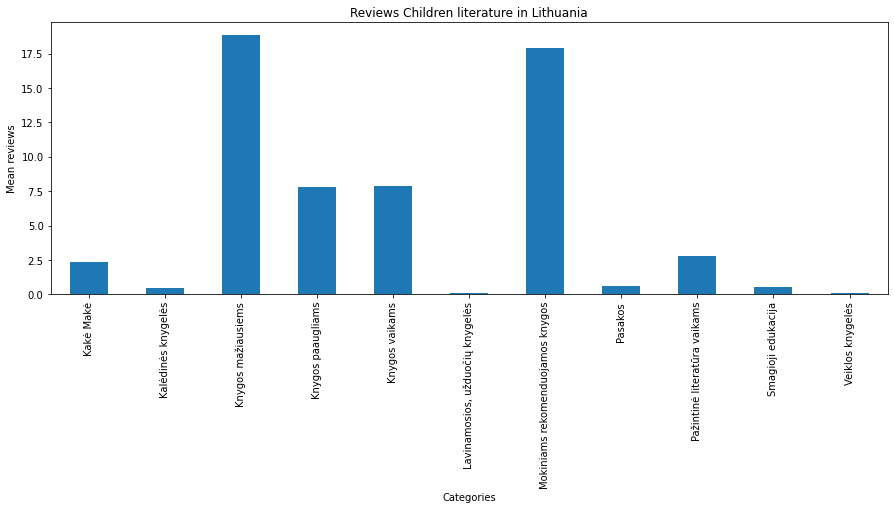

In [ ]:
df_sorted_reviews = df_lithuania.sort_values(by="review", ascending=False)
print(df_sorted_reviews.head())
dfg = df_lithuania.groupby(['category'])['review'].mean()

dfg.plot(kind='bar', title='Reviews Children literature in Lithuania', ylabel='Mean reviews',
         xlabel='Categories', figsize=(15, 5))


We can see that the books that are the most reviewed are the books for young children and the ones recommended for the school.



**Describing the price**





                      name                                title  review  \
73                           DIDŽIOJI PASAKŲ KNYGA: garsieji...       0   
81          Eglė Labukienė   Kakė Makė. Abėcėlė. Lavinamasis...       0   
122         Eglė Labukienė   Kakė Makė. Abėcėlė. Lavinamasis...       0   
46         Herman Melville           Mobis Dikas, arba Banginis       3   
129  Ernst Theodor Amad...  SPRAGTUKAS IR PELIŲ KARALIUS: pi...       1   

     price            category  
73   84.99             Pasakos  
81   30.79           Kakė Makė  
122  30.79    Veiklos knygelės  
46   26.99   Knygos paaugliams  
129  21.25  Kalėdinės knygelės  


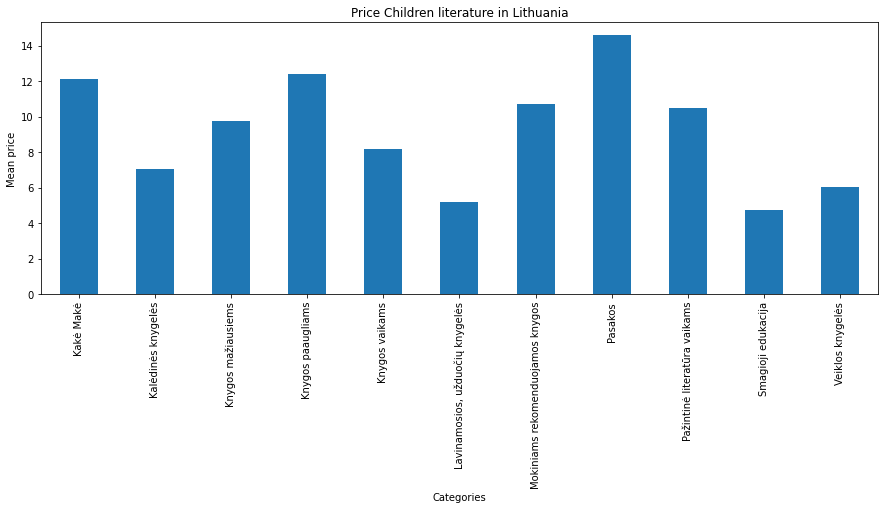

In [ ]:
df_sorted_price = df_lithuania.sort_values(by="price", ascending=False)
print(df_sorted_price.head())
dfg = df_lithuania.groupby(['category'])['price'].mean()

dfg.plot(kind='bar', title='Price Children literature in Lithuania', ylabel='Mean price',
         xlabel='Categories', figsize=(15, 5))

**Correlation between price and reviews**


Text(0.5, 1.0, 'Correlation between the price and the number of reviews')

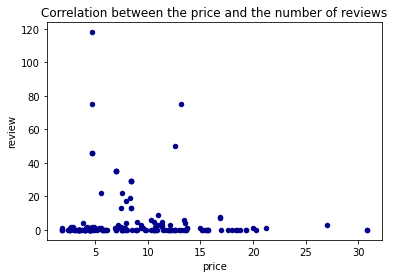

In [ ]:
df_lithuania_no_outliers = df_lithuania.drop([73])
df_lithuania_no_outliers.plot.scatter(x="price", y="review", c="DarkBlue")
plt.title("Correlation between the price and the number of reviews")

# Nationality of the author

I would like to know what percentage of books are written by Lithuanians. Lithuanian diacritical marks ("ąčęėįšųū") may help me to identify books that are written by Lithuanians.

I noticed that the search indeed seemed to admit mainly Lithuanians although at least two persons whose nationality is not Lithuanian were included in the selection (Pavla Hanáčková, of Czech origin and Ester Dobiášová). However, I keep this approach as it gives me a good approximation. I removed Mrs. Hanáčková and Dobiášová with the .remove() function. 

In [ ]:
lit = "[ąčęėįšųūĄČĘĖĮŠŲŪ]"
lit_author = []
for author in df_lithuania["name"]: 
  if re.search(lit, author): 
    lit_author.append(author)
  elif "Vytautas" in author: 
    lit_author.append(author) 
  elif "Linas" in author:
    lit_author.append(author)
  elif "Ruta" in author:
    lit_author.append(author)

lit_author.remove("Pavla Hanáčková")
lit_author.remove("Ester Dobiášová, J...")

print(f"The percentage of books in the corpus written by Lituanians is {round(((len(lit_author))/176)*100,2)}%.")

df_lithuania["lithuanian"] = "N"

for i in range(len(df_lithuania.index)): 
  for author in lit_author: 
    if df_lithuania["name"].iloc[i] == author:
      df_lithuania["lithuanian"].iloc[i] = "Y"
      break 
    else : 
      df_lithuania["lithuanian"].iloc[i] ="N"
      continue

print(df_lithuania.sample(20))


The percentage of books in the corpus written by Lituanians is 18.18%.
                      name                                title  review  \
43           A.F. Steadman        Skandaras ir vienaragių vagis       0   
1     Indrė Pavilonytė,...           Marmiai. Draugystės magija       4   
57   Ester Dobiášová, J...                           Apie šunis       0   
14   Marius Marcinkevič...                         Superbobutės       0   
149            Jules Verne  APLINK ŽEMĘ PER 80 DIENŲ: klasik...       8   
7              Debi Gliori  MYLĖSIU TAVE, KAD IR KAS NUTIKTŲ...      75   
9    Sudarytojas Neil P...   Raudonkepuraitė ir kitos Šarlio...       0   
99                                             Mažylių raidelės       0   
72                                                Baltas vilkas       0   
140             Dawn Casey                       Žiemos pasakos       0   
60                                              Mįslių pasaulis       0   
170        Catherine Casey  K

I want to know if Lithuanians writer get more reviews than non-Lithuanian.

In [ ]:
review_lit = df_lithuania.groupby("lithuanian")["review"].sum()
Lithuanian_average = round(review_lit["Y"]/32, 2)
Non_Lithuanian_average = round(review_lit["N"]/144, 2)
print(f"Books written by Lithuanian writer receive on average {Lithuanian_average} reviews.")
print(f"Books written by non-Lithuanian writer receive on averge {Non_Lithuanian_average} reviews.")


Books written by Lithuanian writer receive on average 10.09 reviews.
Books written by non-Lithuanian writer receive on averge 4.34 reviews.


Let's take out the outlier (Ruta Sepetys) to see the new average. 

In [ ]:
df_lithuania_no_sepetys = df_lithuania.drop(159)
review_lit = df_lithuania_no_sepetys.groupby("lithuanian")["review"].sum()
Lithuanian_average = round(review_lit["Y"]/31, 2)
Non_Lithuanian_average = round(review_lit["N"]/144, 2)
print(f"Books written by Lithuanian writer receive on average {Lithuanian_average} reviews.")
print(f"Books written by non-Lithuanian writer receive on averge {Non_Lithuanian_average} reviews.")

Books written by Lithuanian writer receive on average 6.61 reviews.
Books written by non-Lithuanian writer receive on averge 4.34 reviews.


# TOP 100
Each book has as well a reference if it is in the top100 books on the website. Let's look what percentage that makes. 



In [ ]:
top_list = []
top = soup.select(".top-number")
for element in top: 
  top_list.append(element.get_text())
print(f"The percentage of youth literature books in the TOP100 is {len(set(top_list))}%.")

The percentage of youth literature books in the TOP100 is 6%.
